In [1]:
import h5py
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib

import sys
import shutil
import glob
import optparse
import os
import json
import scipy.stats as stats
import pandas as pd
import numpy as np
import pylab as pl

class struct: pass

In [2]:
def do_regression(t,phi,roi_trace,nrois,tpoints):
    print('Doing regression')
    #doing regression to get amplitude and variance expained
    t=np.transpose(np.expand_dims(t,1))
    tmatrix=np.tile(t,(nrois,1))

    phimatrix=np.tile(phi,(1,tpoints))
    Xmatrix=np.cos(tmatrix+phimatrix)

    beta_array=np.zeros((nrois))
    varexp_array=np.zeros((nrois))
    signal_fit = np.zeros((nrois,tpoints))

    for midx in range(nrois):
        x=np.expand_dims(Xmatrix[midx,:],1)
        y=roi_trace[midx,:]
        mean_y = np.mean(y)
        y=y-mean_y
        beta=np.matmul(np.linalg.pinv(x),y)
        beta_array[midx]=beta
        yHat=x*beta

        signal_fit[midx,:]=np.squeeze(yHat+mean_y)
        SSreg=np.sum((yHat-np.mean(y,0))**2)
        SStotal=np.sum((y-np.mean(y,0))**2)
        varexp_array[midx]=SSreg/SStotal

    return varexp_array, beta_array, signal_fit

def findOccurrences(s, ch):
    return [i for i, letter in enumerate(s) if letter == ch]

In [4]:
opts = struct()
opts.rootdir = '/n/coxfs01/2p-data'
opts.animalid = 'JC105'
opts.session = '20190828'
opts.acquisition = 'FOV1_zoom4p0x'
opts.traceid = 'traces101'
opts.retino_run = 'retino_run1'


#% Set up paths:    
traceid = '%s_s2p'%(opts. traceid)
#% Set up paths:    
acquisition_dir = os.path.join(opts.rootdir, opts.animalid, opts.session, opts.acquisition)
traceid_dir = os.path.join(acquisition_dir, opts.retino_run, 'traces',traceid)

file_dir = os.path.join(traceid_dir,'retino_analysis','files')
run_dir = traceid_dir.split('/traces')[0]
trace_arrays_dir = os.path.join(traceid_dir,'files')


#Output paths
fig_base_dir = os.path.join(traceid_dir,'retino_analysis','figures')
if not os.path.exists(fig_base_dir):
    os.makedirs(fig_base_dir)
file_out_dir = os.path.join(traceid_dir,'retino_analysis','files')
if not os.path.exists(file_out_dir):
    os.makedirs(file_out_dir)



In [6]:
# Get associated RUN info:
runmeta_path = os.path.join(run_dir, '%s.json' % opts.retino_run)
with open(runmeta_path, 'r') as r:
    runinfo = json.load(r)

nslices = len(runinfo['slices'])
nchannels = runinfo['nchannels']
nvolumes = runinfo['nvolumes']
ntiffs = runinfo['ntiffs']
frame_rate = runinfo['frame_rate']

#-----Get info from paradigm file
para_file_dir = os.path.join(run_dir,'paradigm','files')
if not os.path.exists(para_file_dir): os.makedirs(para_file_dir)
para_files =  [f for f in os.listdir(para_file_dir) if f.endswith('.json')]#assuming a single file for all tiffs in run
if len(para_files) == 0:
    # Paradigm info not extracted yet:
    raw_para_files = [f for f in glob.glob(os.path.join(run_dir, 'raw*', 'paradigm_files', '*.mwk')) if not f.startswith('.')]
    print run_dir
    assert len(raw_para_files) == 1, "No raw .mwk file found, and no processed .mwk file found. Aborting!"
    raw_para_file = raw_para_files[0]           
    print "Extracting .mwk trials: %s" % raw_para_file 
    fn_base = os.path.split(raw_para_file)[1][:-4]
    trials = mw.extract_trials(raw_para_file, retinobar=True, trigger_varname='frame_trigger', verbose=True)
    para_fpath = mw.save_trials(trials, para_file_dir, fn_base)
    para_file = os.path.split(para_fpath)[-1]
else:
    assert len(para_files) == 1, "Unable to find unique .mwk file..."
    para_file = para_files[0]

print 'Getting paradigm file info from %s'%(os.path.join(para_file_dir, para_file))

with open(os.path.join(para_file_dir, para_file), 'r') as r:
    parainfo = json.load(r)


#get masks
curr_slice = 'Slice01'#hard-coding planar data for now

masks_fn = os.path.join(file_out_dir,'masks.hdf5')
mask_file = h5py.File(masks_fn, 'r')

iscell = np.array(mask_file[curr_slice]['iscell'])
mask_array = np.array(mask_file[curr_slice]['mask_array'])
mask_file.close()

Getting paradigm file info from /n/coxfs01/2p-data/JC105/20190828/FOV1_zoom4p0x/retino_run1/paradigm/files/parsed_trials_20190828_JC105_FOV1_retino_f1.json


In [ ]:
fid = 1
#for fid in range(1,ntiffs+1):
trace_file = [f for f in os.listdir(trace_arrays_dir) if 'File%03d'%(fid) in f and f.endswith('hdf5')][0]
trace_fn = os.path.join(trace_arrays_dir,trace_file)
print(trace_fn)

rawfile = h5py.File(trace_fn, 'r')

frametimes = np.array(rawfile[curr_slice]['frames_tsec'])
roi_trace = np.transpose(rawfile[curr_slice]['traces']['np_subtracted'])
rawfile.close()

stimulus = parainfo[str(fid)]['stimuli']['stimulus']
stimfreq = parainfo[str(fid)]['stimuli']['scale']

#make figure directory for stimulus type
fig_out_dir = os.path.join(fig_base_dir, stimulus)
if not os.path.exists(fig_out_dir):
    os.makedirs(fig_out_dir)



#Get fft  
print('Getting fft....')
fourier_data = np.fft.fft(roi_trace)


nrois,nframes = roi_trace.shape



#Get magnitude and phase data
print('Analyzing phase and magnitude....')
mag_data=abs(fourier_data)
phase_data=np.angle(fourier_data)

#label frequency bins
freqs = np.fft.fftfreq(nframes, float(1/frame_rate))
idx = np.argsort(freqs)
freqs=freqs[idx]

#sort magnitude and phase data
mag_data=mag_data[:,idx]
phase_data=phase_data[:,idx]

#excluding DC offset from data
freqs=freqs[np.round(nframes/2)+1:]
mag_data=mag_data[:,np.round(nframes/2)+1:]
phase_data=phase_data[:,np.round(nframes/2)+1:]

freq_idx=np.argmin(np.absolute(freqs-stimfreq))#find out index of stimulation freq
top_freq_idx=np.where(freqs>1)[0][0]#find out index of 1Hz, to cut-off zoomed out plot
max_mod_idx=np.argmax(mag_data[:,freq_idx],0)#best pixel index

#unpack values from frequency analysis
mag_array = mag_data[:,freq_idx]                    
phase_array = phase_data[:,freq_idx]      

#get magnitude ratio
tmp=np.copy(mag_data)
np.delete(tmp,freq_idx,1)
nontarget_mag_array=np.sum(tmp,1)
mag_ratio_array=mag_array/nontarget_mag_array

#bootstrap to get null-distribution for mag ratio
nreps = 1000
zscore_bootstrap = np.empty((nrois,))
ratio_array = np.empty((nreps,))
#ridx = 76
for ridx in range(nrois):
    for rep in range(nreps):

        roi_mag = mag_data[ridx,:]
        shuffle_mag = np.random.permutation(roi_mag)
        mag_value = shuffle_mag[freq_idx]  
        tmp  = np.copy(shuffle_mag)
        np.delete(tmp,freq_idx,0)
        nontarget_mag_value=np.sum(tmp,0)
        ratio_array[rep] = mag_value/nontarget_mag_value

    zscore_bootstrap[ridx] = (mag_ratio_array[ridx] - np.mean(ratio_array))/np.std(ratio_array)


#do regression, get some info from fit
t=frametimes*(2*np.pi)*stimfreq
phi=np.expand_dims(phase_array,1)
varexp_array, beta_array, signal_fit = do_regression(t,phi,roi_trace,roi_trace.shape[0],roi_trace.shape[1])

print('Saving data to file')
file_grp = h5py.File(os.path.join(file_out_dir,'File%03d_retino_data.hdf5'%(fid)),  'w')

#file_grp.attrs['frame_rate'] = frame_rate
file_grp.attrs['stimfreq'] = stimfreq



#save data values to structure
if 'mag_array' not in file_grp.keys():
    magset = file_grp.create_dataset('/'.join([curr_slice,'mag_array']),mag_array.shape, mag_array.dtype)
    magset[...] = mag_array
if 'phase_array' not in file_grp.keys():
    phaseset = file_grp.create_dataset('/'.join([curr_slice,'phase_array']),phase_array.shape, phase_array.dtype)
    phaseset[...] = phase_array
if 'mag_ratio_array' not in file_grp.keys():
    ratioset = file_grp.create_dataset('/'.join([curr_slice,'mag_ratio_array']),mag_ratio_array.shape, mag_ratio_array.dtype)
    ratioset[...] = mag_ratio_array
if 'ratio_bootstrap_zscore' not in file_grp.keys():
    bstrapset = file_grp.create_dataset('/'.join([curr_slice,'ratio_bootstrap_zscore']),zscore_bootstrap.shape, zscore_bootstrap.dtype)
    bstrapset[...] = zscore_bootstrap
if 'beta_array' not in file_grp.keys():
    betaset = file_grp.create_dataset('/'.join([curr_slice,'beta_array']),beta_array.shape, beta_array.dtype)
    betaset[...] = beta_array
if 'var_exp_array' not in file_grp.keys():
    varset = file_grp.create_dataset('/'.join([curr_slice,'var_exp_array']),varexp_array.shape, varexp_array.dtype)
    varset[...] = varexp_array

# Add fit signal to retino output:
if 'signal_fit' not in file_grp.keys():
    fitset = file_grp.create_dataset('/'.join([curr_slice,'signal_fit']), signal_fit.shape, signal_fit.dtype)
    fitset[...] = signal_fit

if 'masks' not in file_grp.keys():
    mset = file_grp.create_dataset('/'.join([curr_slice,'masks']),mask_array.shape, mask_array.dtype)
    mset[...] = mask_array
file_grp.close()


#VISUALIZE!!!
print('Visualizing results')
print('Output folder: %s'%(fig_out_dir))
#visualize pixel-based result

#make figure directory for stimulus type
fig_dir = os.path.join(fig_out_dir, 'File%03d_%s' % (fid, curr_slice),'spectrum')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

for midx in range(nrois):
    fig_name = 'full_spectrum_mask%04d.png' %(midx)
    fig=plt.figure()
    plt.plot(freqs,mag_data[midx,:])
    plt.xlabel('Frequency (Hz)',fontsize=16)
    plt.ylabel('Magnitude',fontsize=16)
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    plt.axvline(x=freqs[freq_idx], ymin=ymin, ymax = ymax, linewidth=1, color='r')
    plt.savefig(os.path.join(fig_dir,fig_name))
    plt.close()

for midx in range(nrois):
    fig_name = 'zoom_spectrum_mask%04d.png' %(midx)
    fig=plt.figure()
    plt.plot(freqs[0:top_freq_idx],mag_data[midx,0:top_freq_idx])
    plt.xlabel('Frequency (Hz)',fontsize=16)
    plt.ylabel('Magnitude',fontsize=16)
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    plt.axvline(x=freqs[freq_idx], ymin=ymin, ymax = ymax, linewidth=1, color='r')
    plt.savefig(os.path.join(fig_dir,fig_name))
    plt.close()


fig_dir = os.path.join(fig_out_dir, 'File%03d_%s' % (fid, curr_slice),'timecourse')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [19]:
stimperiod_t=np.true_divide(1,stimfreq)
stimperiod_frames=stimperiod_t*frame_rate
periodstartframes=np.round(np.arange(0,len(frametimes),stimperiod_frames))[:]
periodstartframes = periodstartframes.astype('int')

In [15]:
stimperiod_frames

343.48307692307691

In [16]:
len(frametimes)

4121

In [17]:
4121/343.4

12.000582411182295

In [20]:
len(periodstartframes)

12

In [7]:
for midx in range(nrois):
    fig_name = 'timecourse_fit_mask%04d.png' %(midx)
    fig=plt.figure()
    plt.plot(frametimes,roi_trace[midx,:],'b')
    plt.plot(frametimes,signal_fit[midx,:],'r')
    plt.xlabel('Time (s)',fontsize=16)
    plt.ylabel('Pixel Value',fontsize=16)
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    for f in periodstartframes:
            plt.axvline(x=frametimes[f], ymin=ymin, ymax = ymax, linewidth=1, color='k')
    axes.set_xlim([frametimes[0],frametimes[-1]])
    plt.savefig(os.path.join(fig_dir,fig_name))
    plt.close()

/n/coxfs01/2p-data/JC105/20190828/FOV1_zoom4p0x/retino_run1/traces/traces101_s2p/files/File001_rawtraces_s2p.hdf5
Getting fft....
Analyzing phase and magnitude....
Doing regression
Saving data to file
Visualizing results
Output folder: /n/coxfs01/2p-data/JC105/20190828/FOV1_zoom4p0x/retino_run1/traces/traces101_s2p/retino_analysis/figures/left


(0.0, 92.263086099999995)

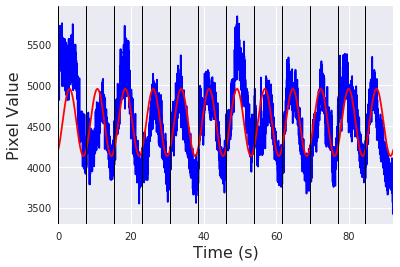

In [21]:
midx = 0 

fig=plt.figure()
plt.plot(frametimes,roi_trace[midx,:],'b')
plt.plot(frametimes,signal_fit[midx,:],'r')
plt.xlabel('Time (s)',fontsize=16)
plt.ylabel('Pixel Value',fontsize=16)
axes = plt.gca()
ymin, ymax = axes.get_ylim()
for f in periodstartframes:
        plt.axvline(x=frametimes[f], linewidth=1, color='k')
axes.set_xlim([frametimes[0],frametimes[-1]])

In [10]:
periodstartframes

array([   0,  343,  687, 1030, 1374, 1717, 2061, 2404, 2748, 3091, 3435])

In [12]:
len(periodstartframes)

11

In [22]:
# #Read in average image (for viuslization)
masks_fn = os.path.join(file_out_dir,'masks.hdf5')
mask_file = h5py.File(masks_fn, 'r')

im0 = np.array(mask_file[curr_slice]['meanImg'])
mask_file.close()
szx,szy = im0.shape



im1 = np.uint8(np.true_divide(im0,np.max(im0))*255)
im2 = np.dstack((im1,im1,im1))

#set phase map range for visualization
phase_array_disp=np.copy(phase_array)
phase_array_disp[phase_array<0]=-phase_array[phase_array<0]
phase_array_disp[phase_array>0]=(2*np.pi)-phase_array[phase_array>0]



#mark rois
magratio_roi = np.empty((szy,szx))
magratio_roi[:] = np.NAN

mag_roi = np.copy(magratio_roi)
varexp_roi = np.copy(magratio_roi)
phase_roi = np.copy(magratio_roi)

for midx in range(nrois):
    if iscell[midx]:
        maskpix = np.where(np.squeeze(mask_array[midx,:,:]))
        #print(len(maskpix))
        magratio_roi[maskpix]=mag_ratio_array[midx]
        mag_roi[maskpix]=mag_array[midx]
        varexp_roi[maskpix]=varexp_array[midx]
        phase_roi[maskpix]=phase_array_disp[midx]

fig_dir = fig_out_dir
data_str = 'File%03d_%s'%(fid,curr_slice)

sns.set_style("darkgrid", {'axes.grid' : True})

fig_name = 'phase_mag_ratio_joint_%s.png' % data_str 
p = sns.jointplot(phase_array_disp,mag_ratio_array,xlim = (0,2*np.pi))
p.ax_joint.legend_.remove()
p.set_axis_labels(xlabel='Phase', ylabel='Mag Ratio',fontsize = 15)
p.savefig(os.path.join(fig_dir,fig_name))
plt.close()

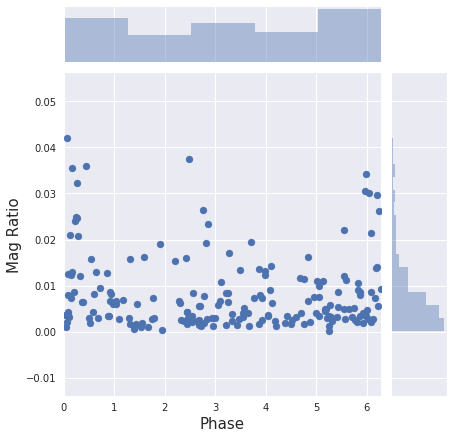

In [24]:
p = sns.jointplot(phase_array_disp,mag_ratio_array,xlim = (0,2*np.pi))
p.ax_joint.legend_.remove()
p.set_axis_labels(xlabel='Phase', ylabel='Mag Ratio',fontsize = 15)

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})


fig_name = 'phase_info_%s.png' % data_str 
fig=plt.figure()
plt.imshow(im2,'gray')
plt.imshow(phase_roi,'nipy_spectral',alpha = 0.5,vmin=0,vmax=2*np.pi)
plt.colorbar()
plt.savefig(os.path.join(fig_dir,fig_name))
plt.close()


fig_name = 'mag_info_%s.png' % data_str 
fig=plt.figure()
plt.imshow(im2,'gray')
plt.imshow(mag_roi, alpha = 0.5)
plt.colorbar()
plt.savefig(os.path.join(fig_dir,fig_name))
plt.close()

fig_name = 'mag_ratio_info_%s.png' % data_str 
fig=plt.figure()
plt.imshow(im2,'gray')
plt.imshow(magratio_roi, alpha = 0.5)
plt.colorbar()
plt.savefig(os.path.join(fig_dir,fig_name))
plt.close()

fig_name = 'varexp_info_%s.png' % data_str 
fig=plt.figure()
plt.imshow(im2,'gray')
plt.imshow(varexp_roi, alpha = 0.5)
plt.colorbar()
plt.savefig(os.path.join(fig_dir,fig_name))
plt.close()

fig_name = 'phase_nice_%s.png' % data_str #curr_file #(tiff_fn[:-4])
dpi = 80
szY,szX = im1.shape
# What size does the figure need to be in inches to fit the image?
figsize = szX / float(dpi), szY / float(dpi)
# Create a figure of the right size with one axes that takes up the full figure
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
# Hide spines, ticks, etc.
ax.axis('off')
ax.imshow(im2,'gray')
ax.imshow(phase_roi,'nipy_spectral',alpha = 0.5,vmin=0,vmax=2*np.pi)
fig.savefig(os.path.join(fig_dir,fig_name), dpi=dpi, transparent=True)
plt.close()